In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

os.environ["KAGGLE_USERNAME"] = ""
os.environ["KAGGLE_KEY"] = ""

In [3]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 764M/778M [00:05<00:00, 179MB/s]
100% 778M/778M [00:05<00:00, 153MB/s]


In [4]:
!unzip -q "/content/covid19-radiography-database.zip"

In [5]:
import imageio
import numpy as np
import PIL
import sklearn
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [6]:
root_folder = '/content/COVID-19_Radiography_Dataset/'

# Display image
nparray = np.array(PIL.Image.open(root_folder + 'COVID/images/COVID-1.png'))
print(nparray.shape)

img = io.imread(root_folder + 'COVID/images/COVID-1.png')
print(img.shape)
print(type(img))

(299, 299)
(299, 299)
<class 'numpy.ndarray'>


In [7]:
from skimage.util import img_as_int
def load_dataset(path, n_images, resolution):
    """
    Args:
        path: path to the dataset
        n_images: number of images to load
    Return:
        dataset: a list of numpy arrays containing the images
    """
    dataset = []
    # Read all images in the folder
    for filename in os.listdir(path+'images/')[:n_images]:
        # Read image with numpy
        image_as_np = io.imread(path + 'images/' + filename, as_gray=True)
        # print(image_as_np.dtype)
        mask_as_np = io.imread(path + 'masks/' + filename, as_gray=True)
        # print(mask_as_np.dtype)
        # Scale image to 255 to convert it to dtype unit8 from float64
        mask_as_np = 255 * mask_as_np
        mask_as_np = mask_as_np.astype(np.uint8) 
  
        mask_as_np = resize(mask_as_np, (resolution, resolution), anti_aliasing=True)
        image_as_np = resize(image_as_np, (resolution, resolution), anti_aliasing=True)
  
        im_mask_as_np = (image_as_np * (mask_as_np != 0))
        # Add image to the dataset
        dataset.append(im_mask_as_np)

    return dataset

[0.64157108 0.59120971 0.54458824 ... 0.63335127 0.66780392 0.70749931]


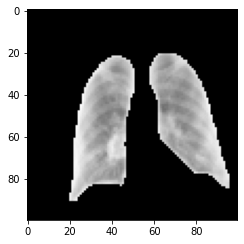

In [8]:
from matplotlib import pyplot as plt 

plt.rcParams["figure.figsize"] = [7.00, 3.50] 
plt.rcParams["figure.autolayout"] = True 

data = load_dataset(root_folder + 'COVID/', 1, 100)[0]

print(data[np.where(data != 0)])

plt.imshow(data, cmap='gray') 
plt.show()

In [10]:
root_folder = '/content/COVID-19_Radiography_Dataset/'

N_IMAGES = -1
# Resize images to 10x10
RESOLUTION = 64
covid_images = load_dataset(root_folder + 'COVID/', N_IMAGES, RESOLUTION)
lung_opacity_images = load_dataset(root_folder + 'Lung_Opacity/', N_IMAGES, RESOLUTION)
normal_images = load_dataset(root_folder + 'Normal/', N_IMAGES, RESOLUTION)
viral_images = load_dataset(root_folder + 'Viral Pneumonia/', N_IMAGES, RESOLUTION)


# covid_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in covid_images]
# lung_opacity_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in lung_opacity_images]
# normal_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in normal_images]
# viral_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in viral_images]

print(covid_images[0].shape, lung_opacity_images[0].shape, normal_images[0].shape, viral_images[0].shape)

# Flatten images
covid_images = [image.flatten() for image in covid_images]
lung_opacity_images = [image.flatten() for image in lung_opacity_images]
normal_images = [image.flatten() for image in normal_images]
viral_images = [image.flatten() for image in viral_images]

print(covid_images[0].shape, lung_opacity_images[0].shape, normal_images[0].shape, viral_images[0].shape)

X = np.concatenate((covid_images, lung_opacity_images, normal_images, viral_images))
print(X.shape)

(64, 64) (64, 64) (64, 64) (64, 64)
(4096,) (4096,) (4096,) (4096,)
(21161, 4096)


In [11]:
COVID_LABEL = 1
LUNG_OPACITY_LABEL = 2
NORMAL_LABEL = 3
VIRAL_LABEL = 4

labels = np.array([COVID_LABEL] * len(covid_images) + [LUNG_OPACITY_LABEL] * len(lung_opacity_images) + [NORMAL_LABEL] * len(normal_images) + [VIRAL_LABEL] * len(viral_images))
print(labels)

[1 1 1 ... 4 4 4]


In [12]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14812, 4096) (6349, 4096) (14812,) (6349,)


In [13]:
def get_accuracy_for_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [14]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, GaussianNB()))

0.18475350448889588


In [15]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, ComplementNB()))

0.5507954008505277


In [16]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, BernoulliNB()))

0.5213419436131674


In [17]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, MultinomialNB()))

0.5197668924240038


In [19]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, RandomForestClassifier()))

0.7596471885336273


In [21]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, SVC()))

0.7590171680579619


In [20]:
print(get_accuracy_for_model(X_train, X_test, y_train, y_test, MLPClassifier(learning_rate='adaptive', max_iter=300)))

0.7215309497558671
